## 1. GCN的另一个缺陷

GraphSAGE通过采样邻居的策略解决了GCN只能采用Full Patch训练的问题。在GAT中指出了GCN的另外两个缺点：

1) 无法为不同的Neighbor节点指定不同的权重，也就说GCN对于同阶邻域上的不同邻居分配的权重是完全相同的，这限制了GCN模型对于空间信息相关系的捕捉能力；

2) GCN聚合临近节点特征的方式与图(Graph)的结构密切相关，这限制了训练所得模型在其它图结构上的泛化能力；

## 2. 引入注意力(Attention)机制

Graph Attention Network(GAT)将注意力(Attention)机制对邻居节点特征进行加权求和，不同的邻居节点有不同的权重；不同临近节点特征的权重完全取决于节点的特征，独立于图(Graph)结构，从而也能获得更好的泛化能力。

Graph Attention Network(GAT)与Graph Convolution Network的核心区别在于：如何聚合一阶邻居的信息。

1. GCN中聚合一阶邻居信息的过程如下：

$$
h_{i}^{(l+1)}=\sigma\left(\sum_{j \in \mathcal{N}(i)} \frac{1}{c_{i j}} W^{(l)} h_{j}^{(l)}\right)
$$

其中,$\mathcal{N}(i)$是所有一阶邻居节点，$c_{ij}$是基于图(Graph)结构的标准化常数，$W^{(l)}$是所有一阶相邻节点共享的权重参数。

2. GAT中聚合一阶邻居的信息的过程如下:

$$
\begin{aligned}
z_{i}^{(l)} &=W^{(l)} h_{i}^{(l)} \\
e_{i j}^{(l)} &=\operatorname{LeakyReLU}\left(\vec{a}^{T(l)}\left(z_{i}^{(l)} \| z_{j}^{(l)}\right)\right) \\
\alpha_{i j}^{(l)} &=\frac{\exp \left(e_{i j}^{(l)}\right)}{\sum_{k \in \mathcal{N}(i)} \exp \left(e_{i k}^{(l)}\right)} \\
h_{i}^{(l+1)} &=\sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{i j}^{(l)} z_{j}^{(l)}\right)
\end{aligned}
$$

它与GCN的本质区别在于，它将GCN中聚合邻居节点特征的标准化常数$C_{ij}$替换为注意力权重函数。


## 3. Graph Attention Model

下面一步步将公式转换为代码。

1.首先对输入节点进行进行一次线性变换，从而对顶点的特征进行增维，这是一种常见的特征增强（Feature Augment)的方法。

$$
z_{i}^{(l)} =W^{(l)} h_{i}^{(l)}
$$

In [26]:
class MultiHeadGATLayer(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim,
                 attn_heads = 1,
                 # ....
                 kernel_initializer = 'glorot_uniform'):

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.attn_heads = attn_heads

        self.kernel_initializer = kernel_initializer
        
        # ...

        self.kernels = []

        super(MultiHeadGATLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) >= 2

        for head in range(self.attn_heads):
            kernel = self.add_weight(shape=(self.in_dim, self.out_dim),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     name='kernel_{}'.format(head))
            self.kernels.append(kernel)
            
            # ....

        self.built = True

    def call(self, inputs, training):
        X = inputs[0]

        outputs = []
        for head in range(self.attn_heads):

            kernel = self.kernels[head]

            features = tf.matmul(X, kernel)



2.计算注意力系数：

$$
e_{i j}^{(l)} =\operatorname{LeakyReLU}\left(\vec{a}^{T(l)}\left(z_{i}^{(l)} \| z_{j}^{(l)}\right)\right)
$$

对于变换后的节点特征进行拼接(concatenate)，然后通过矩阵a把拼接后的高维特征映射到一个实数上，这是通过Single Layer Feedforward Neural Network实现的，网络的激活函数是LeakyReLu。

> 什么是LeakyReLu函数？
> 
> ReLu是将所有的负值都设为零，而LeakyReLu是给所有负值赋予一个非零斜率，在本论文中以数学的方式我们可以表示为：
> $$y_{i}=\left\{\begin{array}{ll}
x_{i} & \text { if } x_{i} \geq 0 \\
0.2 & \text { if } x_{i} \leq 0
\end{array}\right.$$
>

显然，节点i和节点j的相关性是通过可学习的参数W和a(\*)完成的。


完整的注意力机制公式如下：

$$
\alpha_{i j}=\frac{\exp \left(\operatorname{Leaky} \operatorname{Re} L u\left(\overrightarrow{\mathrm{a}}^{T}\left[W \vec{h}_{i}|| W \vec{h}_{j}\right]\right)\right)}{\sum_{k \in N_{i}} \exp \left(\operatorname{Leaky} \operatorname{Re} L u\left(\overrightarrow{\mathrm{a}}^{T}\left[W \vec{h}_{i}|| W \vec{h}_{k}\right]\right)\right)}
$$

效果如下图所示:

![](images/mark_attention.png)

这里的Attention论文作者称之为Mask Graph Attention，这是因为Attention机制同事考虑了Graph的结构，注意力机制只在邻居节点上进行。

In [27]:
def call(self, inputs, training):
    X = inputs[0]
    A = inputs[1]

    N = X.shape[0]

    outputs = []
    for head in range(self.attn_heads):

        kernel = self.kernels[head]

        features = tf.matmul(X, kernel)

        concat_features = tf.concat(\
                [tf.reshape(tf.tile(features, [1, N]), [N * N, -1]),\
                tf.tile(features, [N, 1])], axis = 1)

        concat_features = tf.reshape(concat_features, [N, -1, 2 * self.out_dim])

        atten_kernel = self.atten_kernels[head]
            
        dense = tf.matmul(concat_features, atten_kernel)

        dense = tf.keras.layers.LeakyReLU(alpha=0.2)(dense)

        dense = tf.reshape(dense, [N, -1])

        zero_vec = -9e15 * tf.ones_like(dense)
        attention = tf.where(A > 0, dense, zero_vec)

        dense = tf.keras.activations.softmax(attention, axis = -1)

        dropout_attn = tf.keras.layers.Dropout(self.dropout_rate)(dense, training = training)
        dropout_feat = tf.keras.layers.Dropout(self.dropout_rate)(features, training = training)

        node_features = tf.matmul(dropout_attn, dropout_feat)
        
        if self.use_bias:
            node_features = tf.add(node_features, self.biases[head])

        if self.activation is not None:
            node_features = self.activation(node_features)

         # ...

3. Multi-head Attention

如同卷积神经网络(CNN)中滤波核一样，作者发现将多个Attention拼接起来，每个Attention结构可以学习到不同的空间特征，可以进一步提升网络的表达能力。

Attention的拼接的方式为concat或者avg。

$$
h_{i}^{\prime}=\|_{k=1}^{K} \sigma\left(\sum_{j \in \mathcal{N}_{i}} \alpha_{i j}^{k} W^{k} h_{j}\right)
$$

$$
\vec{h}_{i}^{\prime}=\sigma\left(\frac{1}{K} \sum_{k=1}^{K} \sum_{j \in \mathcal{N}_{i}} \alpha_{i j}^{k} \mathbf{W}^{k} \vec{h}_{j}\right)
$$

![](images/multi_head_attention.png)

In [28]:
def call(self, inputs, training):

    outputs = []
    for head in range(self.attn_heads):

        # attention...
        
        outputs.append(node_features)

    if self.attn_heads_reduction == 'concat':
        output = tf.concat(outputs, axis = -1)
    else:
        output = tf.reduce_mean(tf.stack(outputs), axis=-1)

    return output

# 4. 网络训练过程

训练数据仍然采用Cora DataSet，这里不再详细介绍。数据获取的代码与GraphSAGE也几乎完全相同。这里一个核心的区别是，我把整个Graph切成一个个的小图，同时把Graph的Edge也做了切割，保证Gapha的Edge与Node完全匹配。

In [ ]:
def train():
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
            batch_src_label = train_label[batch_src_index].astype(float)

            batch_sampling_x = data.x[batch_src_index]
            batch_adj = data.adj[np.ix_(batch_src_index, batch_src_index)]

            loss = 0.0
            with tf.GradientTape() as tape:
                batch_train_logits = model([batch_sampling_x, batch_adj], training = True)
                loss = loss_object(batch_src_label, batch_train_logits)
                grads = tape.gradient(loss, model.trainable_variables)

                optimizer.apply_gradients(zip(grads, model.trainable_variables))

最后对网络进行训练(Trainning).

Process data ...
Loading cora dataset...
Dataset has 2708 nodes, 5429 edges, 1433 features.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000 train accuracy: 0.7599999904632568 val accuracy: 0.5028571486473083 test accuracy:0.40625
Epoch 001 train accuracy: 0.9266666769981384 val accuracy: 0.5400000214576721 test accuracy:0.4778079688549042
Epoch 002 train accuracy: 0.9666666388511658 val accuracy: 0.5571428537368774 test accuracy:0.5294383764266968
Epoch 003 train accuracy: 0.9800000190734863 val accuracy: 0.5857142806053162 test accuracy:0.

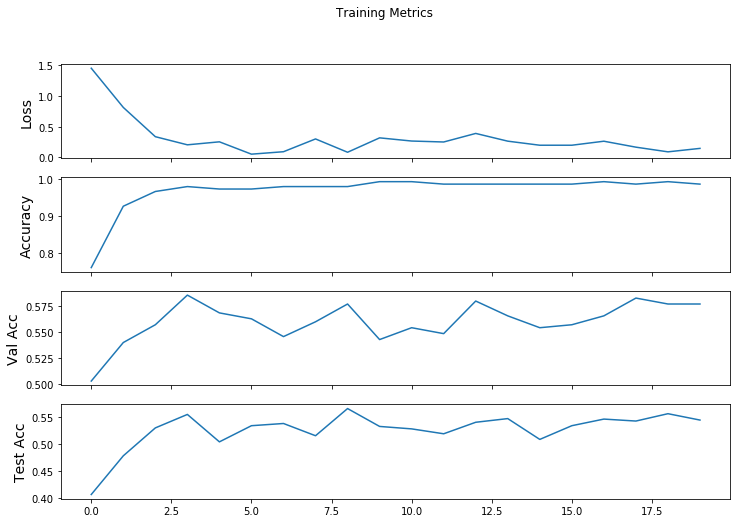

In [1]:
from train_batch import train

train()

最终的效果如上图所示，在训练集和验证集上的效果均比GraphSAGE有较大差距，并且波动很大，具体原因待进一步追查！